In [1]:
import os
import torch
import torch.nn as nn
import json

from config import get_config
from train_utils.gpu_utils import get_device_summary
from data.loader import get_dataloaders
from models.model import create_model
from train_utils.resume import init_resume_state
from train_utils.resume import fill_trackers_from_history
from train_utils.resume import load_pretrained_model
from train_utils.training_loop import run_training_loop
from train_utils.scheduler_utils import create_scheduler
from train_utils.training_summary import finalize_training_summary
from train_utils.training_summary import print_best_model_summary
from train_utils.plot_metrics import plot_train_val_metrics
from train_utils.plot_metrics import plot_loss_accuracy
from train_utils.plot_metrics import plot_confusion_matrices


In [2]:
# cfg=get_config(config_path="config/convnext_fb_in22k_ft_in1k_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/convnext_fb_in1k_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/convnext_gaussian_bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/efficientnet_bs512_ep50_lr1e-01_ds1000_sched-RLRP.yml")
# cfg=get_config(config_path="config/vit_" \
# "bs512_ep50_lr1e-04_ds1000.yml")
# cfg=get_config(config_path="config/mambaout_base_plus_rw_bs32_ep50_lr1e-04_ds1000-g1.yml")
# cfg=get_config(config_path="config/mambaout_base_plus_rw_bs16_ep50_lr1e-04_ds1008_g500_sched-RLRP.yml")

# from experiments.exp_mamaba_vit_stack.models.hybrid_mamba_vit import create_model
# cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/" \
# "experiments/exp_mamaba_vit_stack/config/" \
# "hybrid_mambaout_base_plus_rw_ViT_tiny_patch16_224_bs64_ep1_lr1e-04_ds1008_g500_sched-RLRP.yml")

from models.model_vit import create_model
cfg=get_config(config_path="/home/arsalan/wsu-grid/ml-jet-param-predictor/" \
"experiments/exp_preload_trained_model_and_train_more/config/" \
"vit_tiny_patch16_224_gaussian_bs32_ep50_lr1e-04_ds1008_g500_sched-RLRP_preload.yml")
# cfg=get_config()
print(json.dumps(vars(cfg), indent=2))

[INFO] Config Path: /home/arsalan/wsu-grid/ml-jet-param-predictor/experiments/exp_preload_trained_model_and_train_more/config/vit_tiny_patch16_224_gaussian_bs32_ep50_lr1e-04_ds1008_g500_sched-RLRP_preload.yml
[INFO] Detected native Ubuntu host: DS044955
[INFO] Using dataset root: /home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled
[INFO] Using dataset_size from config: 1008
{
  "model_tag": "ViT_tiny_patch16_224_gaussian_g500",
  "backbone": "vit_gaussian",
  "batch_size": 32,
  "epochs": 50,
  "learning_rate": 0.0001,
  "patience": 12,
  "input_shape": [
    1,
    32,
    32
  ],
  "global_max": 121.79151153564453,
  "dataset_root_dir": "/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_7200000_balanced_unshuffled",
  "train_csv": "/home/arsalan/Projects/110_JetscapeML/hm

In [3]:
os.makedirs(cfg.output_dir, exist_ok=True)
print(f"[INFO] Saving all outputs to: {cfg.output_dir}")

[INFO] Saving all outputs to: experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_g500_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded


In [4]:
device= get_device_summary()

=== NVIDIA-SMI ===
Fri Aug 15 16:37:23 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.247.01             Driver Version: 535.247.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070        Off | 00000000:01:00.0  On |                  N/A |
| 30%   32C    P5              24W / 220W |    817MiB /  8192MiB |     26%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------

In [5]:
# Data
train_loader, val_loader, test_loader = get_dataloaders(cfg, device=device)

[INFO] Training samples: 806
[INFO] Validation samples: 101
[INFO] Test samples: 101
[INFO] Length of training dataloader: 26
[INFO] Length of validation dataloader: 4
[INFO] Length of test dataloader: 4


In [6]:
# Model and optimizer
model, optimizer = create_model(cfg.backbone, cfg.input_shape, cfg.learning_rate)
model.to(device)

Using ViT model: vit_tiny_patch16_224, pretrained: False


ViTClassifier(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none

In [7]:
if torch.cuda.device_count() > 1:
    print(f"Parallelizing model across {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)
elif torch.cuda.device_count() == 1:
    print("No parallelization, using single GPU")
elif torch.cuda.device_count() == 0:
    print("No GPU available, using CPU")

No parallelization, using single GPU


In [8]:
scheduler = create_scheduler(optimizer, cfg, train_loader=train_loader)

In [9]:
criterion = {
    # 'energy_loss_output': nn.BCELoss(),
    'energy_loss_output': nn.BCEWithLogitsLoss(),
    'alpha_output': nn.CrossEntropyLoss(),
    'q0_output': nn.CrossEntropyLoss()
}
print(f"[INFO] Loss functions:{criterion}")

[INFO] Loss functions:{'energy_loss_output': BCEWithLogitsLoss(), 'alpha_output': CrossEntropyLoss(), 'q0_output': CrossEntropyLoss()}


In [10]:
print(f"[INFO] Init Training Trackers")
train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list = [], [], [],[]
train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list = [], [], [], []

print(f"[INFO] Init Validation Trackers")
val_loss_energy_list, val_loss_alpha_list,val_loss_q0_list,val_loss_list = [], [], [], []
val_acc_energy_list, val_acc_alpha_list,val_acc_q0_list ,val_acc_list = [],[],[],[]

[INFO] Init Training Trackers
[INFO] Init Validation Trackers


In [11]:
model, optimizer, start_epoch, best_acc, early_stop_counter, best_epoch, best_metrics, training_summary, all_epoch_metrics,summary_status = init_resume_state( model, optimizer, device,cfg)

[INFO] Init Resume/Training Parameters
[INFO] Starting fresh training run by initializing training summary
[INFO] 📄 Training summary saved to: experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_g500_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/training_summary.json


In [12]:
fill_trackers_from_history(
    all_epoch_metrics,
    train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list,
    train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list,
    val_loss_energy_list, val_loss_alpha_list, val_loss_q0_list, val_loss_list,
    val_acc_energy_list, val_acc_alpha_list, val_acc_q0_list, val_acc_list,
    summary_status, best_epoch
)

In [13]:
model, preloaded = load_pretrained_model(model, device, cfg)


[INFO] 🔄 Preloading model weights from training_output/ViT_tiny_patch16_224_gaussian_g500_bs32_ep50_lr1e-04_ds7200000_g500_sched_ReduceLROnPlateau/best_model.pth
[INFO] ✅ Pretrained weights loaded successfully.


In [ ]:
# for testing
# train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
# print(f"[INFO] Training metrics: {train_metrics}")

In [14]:
best_epoch,best_acc,best_metrics=run_training_loop(
                      cfg,train_loader,val_loader,
                      device, model,criterion,
                      optimizer,scheduler,
                      start_epoch,early_stop_counter,
                      best_acc,best_metrics,best_epoch,
                      train_loss_list,
                        train_loss_energy_list,
                        train_loss_alpha_list,
                        train_loss_q0_list,
                        train_acc_list,
                        train_acc_energy_list,
                        train_acc_alpha_list,
                        train_acc_q0_list,
                        val_loss_list,
                        val_loss_energy_list,
                        val_loss_alpha_list,
                        val_loss_q0_list,
                        val_acc_list,
                        val_acc_energy_list,
                        val_acc_alpha_list,
                        val_acc_q0_list,
                        all_epoch_metrics)

[INFO] Epoch 1/50


[INFO] Epoch 1: Energy Acc =1.0000, αs Acc = 0.8812, Q0 Acc = 0.5941, Total Acc = 0.4950
[INFO] Epoch 1: Energy Loss =0.0000, αs Loss = 0.1578, Q0 Loss = 0.8508, Total Loss = 1.0086
📉 Current LR: 0.0001
[INFO] Epoch 1: Saving metrics to disk
💾 Last model saved at epoch 1
✅ Best model saved at epoch 1 with total accuracy: 0.4950
[INFO] Epoch 2/50


[INFO] Epoch 2: Energy Acc =1.0000, αs Acc = 0.9109, Q0 Acc = 0.6931, Total Acc = 0.6040
[INFO] Epoch 2: Energy Loss =0.0000, αs Loss = 0.1418, Q0 Loss = 0.6775, Total Loss = 0.8193
📉 Current LR: 0.0001
[INFO] Epoch 2: Saving metrics to disk
💾 Last model saved at epoch 2
✅ Best model saved at epoch 2 with total accuracy: 0.6040
[INFO] Epoch 3/50


[INFO] Epoch 3: Energy Acc =1.0000, αs Acc = 0.9208, Q0 Acc = 0.7030, Total Acc = 0.6238
[INFO] Epoch 3: Energy Loss =0.0000, αs Loss = 0.1254, Q0 Loss = 0.5679, Total Loss = 0.6933
📉 Current LR: 0.0001
[INFO] Epoch 3: Saving metrics to disk
💾 Last model saved at epoch 3
✅ Best model saved at epoch 3 with total accuracy: 0.6238
[INFO] Epoch 4/50


[INFO] Epoch 4: Energy Acc =1.0000, αs Acc = 0.9010, Q0 Acc = 0.6634, Total Acc = 0.5644
[INFO] Epoch 4: Energy Loss =0.0000, αs Loss = 0.1316, Q0 Loss = 0.5480, Total Loss = 0.6797
📉 Current LR: 0.0001
[INFO] Epoch 4: Saving metrics to disk
💾 Last model saved at epoch 4
⏳ No improvement. Early stop counter: 1/12
[INFO] Epoch 5/50


[INFO] Epoch 5: Energy Acc =1.0000, αs Acc = 0.9010, Q0 Acc = 0.7525, Total Acc = 0.6535
[INFO] Epoch 5: Energy Loss =0.0000, αs Loss = 0.1553, Q0 Loss = 0.5528, Total Loss = 0.7081
📉 Current LR: 0.0001
[INFO] Epoch 5: Saving metrics to disk
💾 Last model saved at epoch 5
✅ Best model saved at epoch 5 with total accuracy: 0.6535
[INFO] Epoch 6/50


[INFO] Epoch 6: Energy Acc =1.0000, αs Acc = 0.9010, Q0 Acc = 0.7129, Total Acc = 0.6139
[INFO] Epoch 6: Energy Loss =0.0000, αs Loss = 0.1565, Q0 Loss = 0.5859, Total Loss = 0.7425
📉 Current LR: 0.0001
[INFO] Epoch 6: Saving metrics to disk
💾 Last model saved at epoch 6
⏳ No improvement. Early stop counter: 1/12
[INFO] Epoch 7/50


[INFO] Epoch 7: Energy Acc =1.0000, αs Acc = 0.9109, Q0 Acc = 0.7525, Total Acc = 0.6634
[INFO] Epoch 7: Energy Loss =0.0000, αs Loss = 0.1391, Q0 Loss = 0.5454, Total Loss = 0.6845
📉 Current LR: 0.0001
[INFO] Epoch 7: Saving metrics to disk
💾 Last model saved at epoch 7
✅ Best model saved at epoch 7 with total accuracy: 0.6634
[INFO] Epoch 8/50


[INFO] Epoch 8: Energy Acc =1.0000, αs Acc = 0.9208, Q0 Acc = 0.6832, Total Acc = 0.6040
[INFO] Epoch 8: Energy Loss =0.0000, αs Loss = 0.1352, Q0 Loss = 0.5698, Total Loss = 0.7051
📉 Current LR: 0.0001
[INFO] Epoch 8: Saving metrics to disk
💾 Last model saved at epoch 8
⏳ No improvement. Early stop counter: 1/12
[INFO] Epoch 9/50


[INFO] Epoch 9: Energy Acc =1.0000, αs Acc = 0.8812, Q0 Acc = 0.6436, Total Acc = 0.5248
[INFO] Epoch 9: Energy Loss =0.0000, αs Loss = 0.2177, Q0 Loss = 0.8131, Total Loss = 1.0309
📉 Current LR: 0.0001
[INFO] Epoch 9: Saving metrics to disk
💾 Last model saved at epoch 9
⏳ No improvement. Early stop counter: 2/12
[INFO] Epoch 10/50


[INFO] Epoch 10: Energy Acc =1.0000, αs Acc = 0.9109, Q0 Acc = 0.7030, Total Acc = 0.6139
[INFO] Epoch 10: Energy Loss =0.0000, αs Loss = 0.1349, Q0 Loss = 0.5908, Total Loss = 0.7257
📉 Current LR: 0.0001
[INFO] Epoch 10: Saving metrics to disk
💾 Last model saved at epoch 10
⏳ No improvement. Early stop counter: 3/12
[INFO] Epoch 11/50


[INFO] Epoch 11: Energy Acc =1.0000, αs Acc = 0.8812, Q0 Acc = 0.7525, Total Acc = 0.6337
[INFO] Epoch 11: Energy Loss =0.0000, αs Loss = 0.1412, Q0 Loss = 0.5255, Total Loss = 0.6667
📉 Current LR: 0.0001
[INFO] Epoch 11: Saving metrics to disk
💾 Last model saved at epoch 11
⏳ No improvement. Early stop counter: 4/12
[INFO] Epoch 12/50


[INFO] Epoch 12: Energy Acc =1.0000, αs Acc = 0.9109, Q0 Acc = 0.7030, Total Acc = 0.6139
[INFO] Epoch 12: Energy Loss =0.0000, αs Loss = 0.1370, Q0 Loss = 0.5711, Total Loss = 0.7081
📉 Current LR: 5e-05
[INFO] Epoch 12: Saving metrics to disk
💾 Last model saved at epoch 12
⏳ No improvement. Early stop counter: 5/12
[INFO] Epoch 13/50


[INFO] Epoch 13: Energy Acc =1.0000, αs Acc = 0.9208, Q0 Acc = 0.7624, Total Acc = 0.6832
[INFO] Epoch 13: Energy Loss =0.0000, αs Loss = 0.1319, Q0 Loss = 0.5354, Total Loss = 0.6673
📉 Current LR: 5e-05
[INFO] Epoch 13: Saving metrics to disk
💾 Last model saved at epoch 13
✅ Best model saved at epoch 13 with total accuracy: 0.6832
[INFO] Epoch 14/50


[INFO] Epoch 14: Energy Acc =1.0000, αs Acc = 0.9010, Q0 Acc = 0.7327, Total Acc = 0.6337
[INFO] Epoch 14: Energy Loss =0.0000, αs Loss = 0.1319, Q0 Loss = 0.4900, Total Loss = 0.6219
📉 Current LR: 5e-05
[INFO] Epoch 14: Saving metrics to disk
💾 Last model saved at epoch 14
⏳ No improvement. Early stop counter: 1/12
[INFO] Epoch 15/50


[INFO] Epoch 15: Energy Acc =1.0000, αs Acc = 0.9208, Q0 Acc = 0.7426, Total Acc = 0.6634
[INFO] Epoch 15: Energy Loss =0.0000, αs Loss = 0.1356, Q0 Loss = 0.4959, Total Loss = 0.6314
📉 Current LR: 5e-05
[INFO] Epoch 15: Saving metrics to disk
💾 Last model saved at epoch 15
⏳ No improvement. Early stop counter: 2/12
[INFO] Epoch 16/50


[INFO] Epoch 16: Energy Acc =1.0000, αs Acc = 0.9208, Q0 Acc = 0.6535, Total Acc = 0.5743
[INFO] Epoch 16: Energy Loss =0.0000, αs Loss = 0.1405, Q0 Loss = 0.6501, Total Loss = 0.7906
📉 Current LR: 5e-05
[INFO] Epoch 16: Saving metrics to disk
💾 Last model saved at epoch 16
⏳ No improvement. Early stop counter: 3/12
[INFO] Epoch 17/50


[INFO] Epoch 17: Energy Acc =1.0000, αs Acc = 0.9406, Q0 Acc = 0.7426, Total Acc = 0.6832
[INFO] Epoch 17: Energy Loss =0.0000, αs Loss = 0.1708, Q0 Loss = 0.4871, Total Loss = 0.6579
📉 Current LR: 5e-05
[INFO] Epoch 17: Saving metrics to disk
💾 Last model saved at epoch 17
⏳ No improvement. Early stop counter: 4/12
[INFO] Epoch 18/50


[INFO] Epoch 18: Energy Acc =1.0000, αs Acc = 0.9208, Q0 Acc = 0.7129, Total Acc = 0.6337
[INFO] Epoch 18: Energy Loss =0.0000, αs Loss = 0.1415, Q0 Loss = 0.5142, Total Loss = 0.6557
📉 Current LR: 2.5e-05
[INFO] Epoch 18: Saving metrics to disk
💾 Last model saved at epoch 18
⏳ No improvement. Early stop counter: 5/12
[INFO] Epoch 19/50


[INFO] Epoch 19: Energy Acc =1.0000, αs Acc = 0.9109, Q0 Acc = 0.7129, Total Acc = 0.6238
[INFO] Epoch 19: Energy Loss =0.0000, αs Loss = 0.1442, Q0 Loss = 0.5892, Total Loss = 0.7335
📉 Current LR: 2.5e-05
[INFO] Epoch 19: Saving metrics to disk
💾 Last model saved at epoch 19
⏳ No improvement. Early stop counter: 6/12
[INFO] Epoch 20/50


[INFO] Epoch 20: Energy Acc =1.0000, αs Acc = 0.9307, Q0 Acc = 0.7426, Total Acc = 0.6733
[INFO] Epoch 20: Energy Loss =0.0000, αs Loss = 0.1399, Q0 Loss = 0.4849, Total Loss = 0.6248
📉 Current LR: 2.5e-05
[INFO] Epoch 20: Saving metrics to disk
💾 Last model saved at epoch 20
⏳ No improvement. Early stop counter: 7/12
[INFO] Epoch 21/50


[INFO] Epoch 21: Energy Acc =1.0000, αs Acc = 0.9010, Q0 Acc = 0.7228, Total Acc = 0.6238
[INFO] Epoch 21: Energy Loss =0.0001, αs Loss = 0.1699, Q0 Loss = 0.4975, Total Loss = 0.6674
📉 Current LR: 2.5e-05
[INFO] Epoch 21: Saving metrics to disk
💾 Last model saved at epoch 21
⏳ No improvement. Early stop counter: 8/12
[INFO] Epoch 22/50


[INFO] Epoch 22: Energy Acc =1.0000, αs Acc = 0.9109, Q0 Acc = 0.7129, Total Acc = 0.6238
[INFO] Epoch 22: Energy Loss =0.0001, αs Loss = 0.1550, Q0 Loss = 0.4889, Total Loss = 0.6440
📉 Current LR: 2.5e-05
[INFO] Epoch 22: Saving metrics to disk
💾 Last model saved at epoch 22
⏳ No improvement. Early stop counter: 9/12
[INFO] Epoch 23/50


[INFO] Epoch 23: Energy Acc =1.0000, αs Acc = 0.9208, Q0 Acc = 0.7327, Total Acc = 0.6535
[INFO] Epoch 23: Energy Loss =0.0000, αs Loss = 0.1438, Q0 Loss = 0.4990, Total Loss = 0.6429
📉 Current LR: 1.25e-05
[INFO] Epoch 23: Saving metrics to disk
💾 Last model saved at epoch 23
⏳ No improvement. Early stop counter: 10/12
[INFO] Epoch 24/50


[INFO] Epoch 24: Energy Acc =1.0000, αs Acc = 0.9109, Q0 Acc = 0.7327, Total Acc = 0.6436
[INFO] Epoch 24: Energy Loss =0.0001, αs Loss = 0.1603, Q0 Loss = 0.4753, Total Loss = 0.6356
📉 Current LR: 1.25e-05
[INFO] Epoch 24: Saving metrics to disk
💾 Last model saved at epoch 24
⏳ No improvement. Early stop counter: 11/12
[INFO] Epoch 25/50


[INFO] Epoch 25: Energy Acc =1.0000, αs Acc = 0.9208, Q0 Acc = 0.7327, Total Acc = 0.6535
[INFO] Epoch 25: Energy Loss =0.0001, αs Loss = 0.1492, Q0 Loss = 0.4832, Total Loss = 0.6325
📉 Current LR: 1.25e-05
[INFO] Epoch 25: Saving metrics to disk
💾 Last model saved at epoch 25
⏳ No improvement. Early stop counter: 12/12
🛑 Early stopping triggered at epoch 25. Best was at epoch 13.


In [15]:
finalize_training_summary(
    summary=training_summary,
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics,
    output_dir=cfg.output_dir
)
print_best_model_summary(
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics
)

[INFO] 📄 Training summary saved to: experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_g500_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/training_summary.json

🏁 Best Model @ Epoch 13
Total Accuracy: 0.6832

🔹 ENERGY Task
  Accuracy : 1.0000
  Precision: 1.0000
  Recall   : 1.0000
  F1-Score : 1.0000
  Confusion Matrix:
[[26, 0], [0, 75]]

🔹 ALPHA Task
  Accuracy : 0.9208
  Precision: 0.9215
  Recall   : 0.9224
  F1-Score : 0.9210
  Confusion Matrix:
[[32, 2, 0], [1, 30, 4], [0, 1, 31]]

🔹 Q0 Task
  Accuracy : 0.7624
  Precision: 0.7696
  Recall   : 0.7629
  F1-Score : 0.7588
  Confusion Matrix:
[[26, 0, 0, 0], [0, 20, 4, 0], [0, 4, 17, 4], [0, 4, 8, 14]]


📊 Plots saved to:
 - experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_g500_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/loss_accuracy_plot.png
 - experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_g500_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/loss_accuracy_plot.pdf


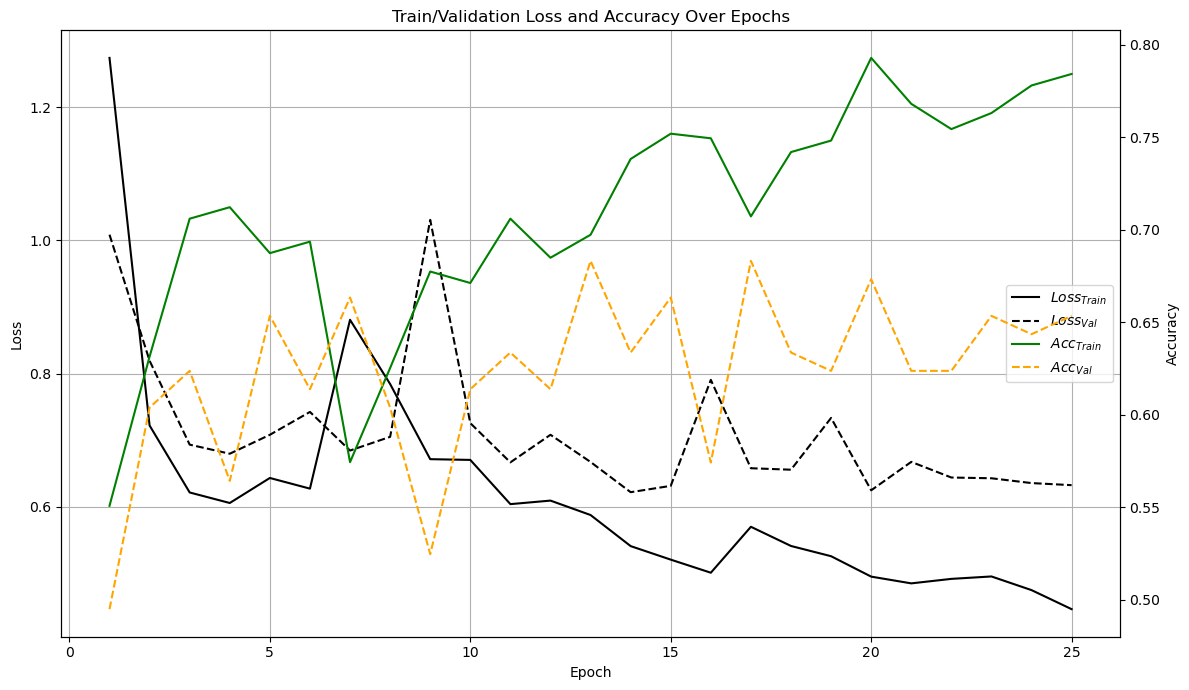

📉 Loss plot saved as:
  - experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_g500_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/train_loss_and_accuracy_per_epoch_plot.png
  - experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_g500_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/train_loss_and_accuracy_per_epoch_plot.pdf


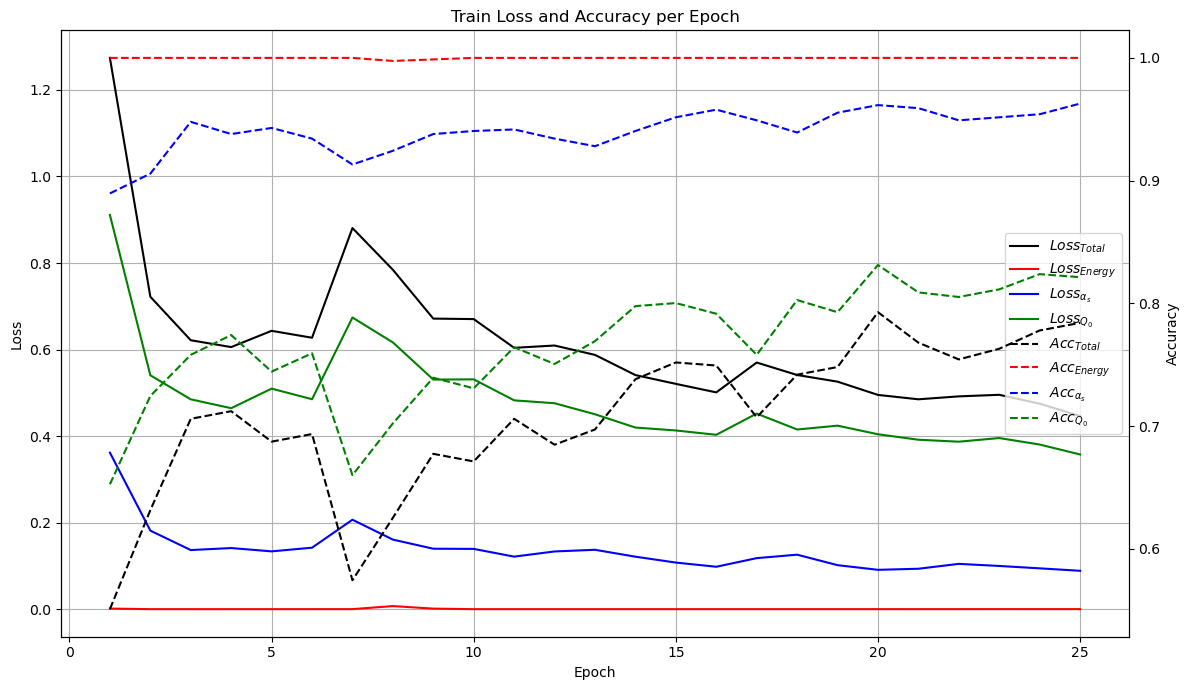

📉 Loss plot saved as:
  - experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_g500_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/validation_loss_and_accuracy_per_epoch_plot.png
  - experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_g500_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/validation_loss_and_accuracy_per_epoch_plot.pdf


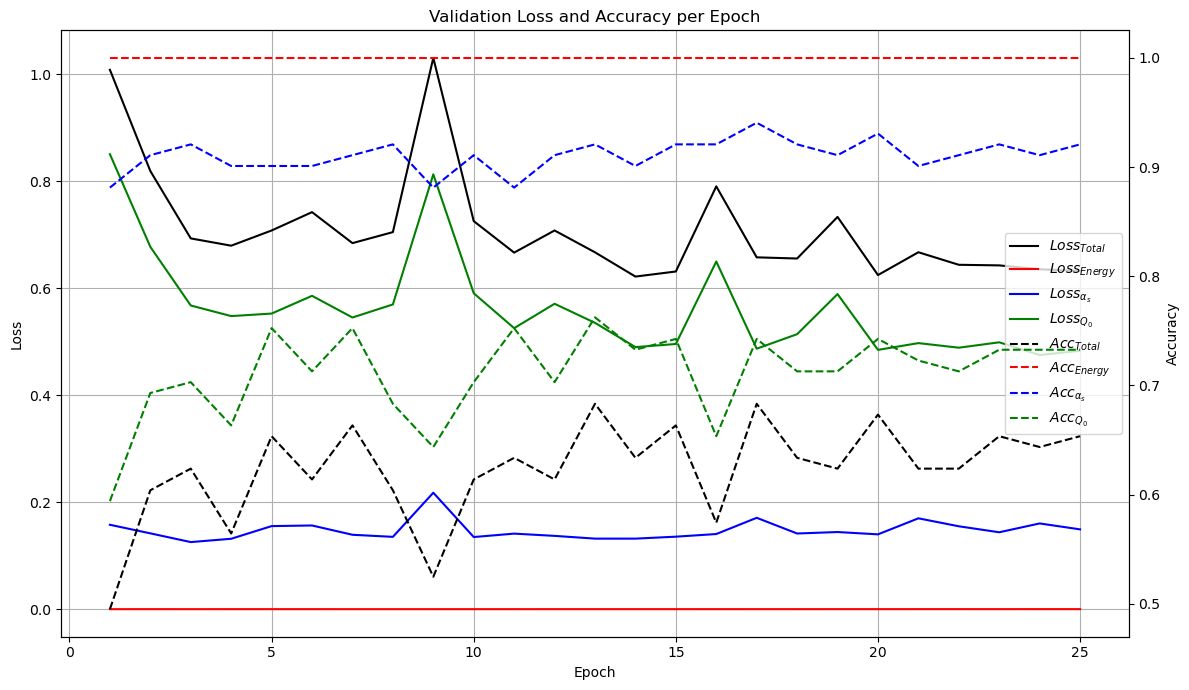

In [16]:
plot_train_val_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list, cfg.output_dir)
plot_loss_accuracy(train_loss_list,
                    train_loss_energy_list,
                    train_loss_alpha_list,
                    train_loss_q0_list,
                    train_acc_list,
                    train_acc_energy_list,
                    train_acc_alpha_list,
                    train_acc_q0_list,
                    cfg.output_dir,
                    title="Train Loss and Accuracy per Epoch")
plot_loss_accuracy(val_loss_list,
                    val_loss_energy_list,
                    val_loss_alpha_list,
                    val_loss_q0_list,
                    val_acc_list,
                    val_acc_energy_list,
                    val_acc_alpha_list,
                    val_acc_q0_list,
                    cfg.output_dir,
                    title="Validation Loss and Accuracy per Epoch")

✅ Saved confusion matrix for energy:
 - experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_g500_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/confusion_plots/confusion_matrix_energy.png
 - experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_g500_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/confusion_plots/confusion_matrix_energy.pdf


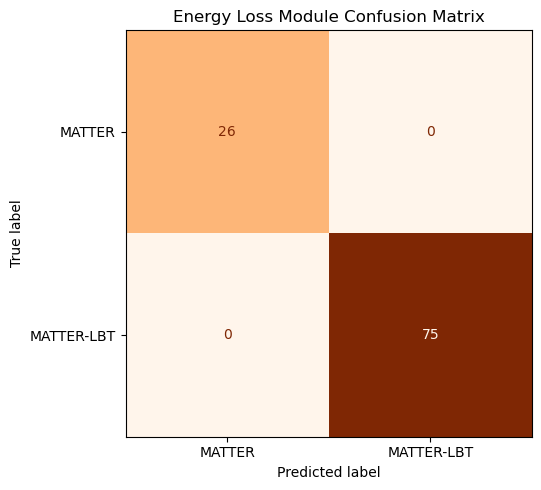

✅ Saved confusion matrix for alpha:
 - experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_g500_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/confusion_plots/confusion_matrix_alpha.png
 - experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_g500_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/confusion_plots/confusion_matrix_alpha.pdf


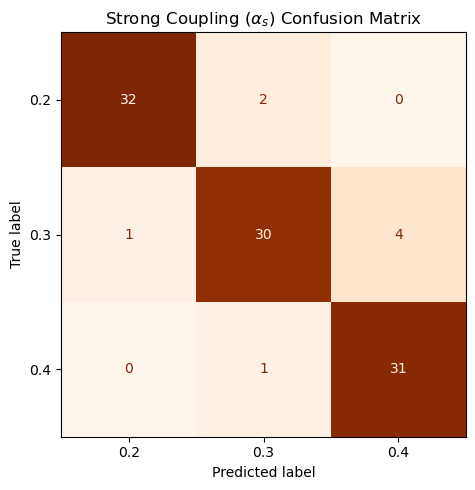

✅ Saved confusion matrix for q0:
 - experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_g500_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/confusion_plots/confusion_matrix_q0.png
 - experiments/exp_preload_trained_model_and_train_more/training_output/ViT_tiny_patch16_224_gaussian_g500_bs32_ep50_lr1e-04_ds1008_g500_sched_ReduceLROnPlateau_preloaded/confusion_plots/confusion_matrix_q0.pdf


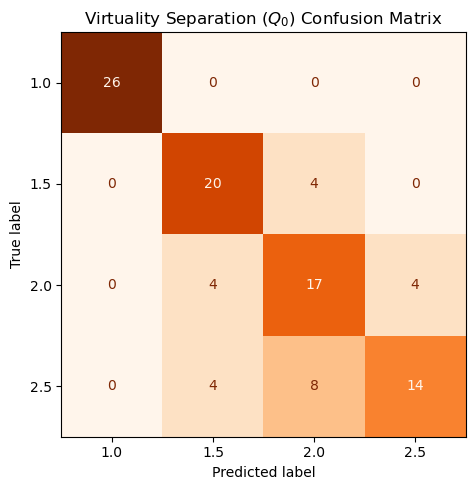

In [17]:
plot_confusion_matrices(best_metrics, output_dir=cfg.output_dir, color_map="Oranges")